<a href="https://colab.research.google.com/github/LEESUSUSUSU/Image_based_question_answering_AI_project/blob/main/DL_project_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import os
# import zipfile
# from tqdm import tqdm

# # 압축 파일 경로
# zip_file_path = "/content/drive/MyDrive/zerobase/project_DL/done.zip"

# # 압축을 풀 디렉토리 경로
# extracted_dir_path = "/content/drive/MyDrive/zerobase/project_DL/data"

# # 압축 해제
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # 압축 파일 내 파일의 개수 추출
#     file_count = len(zip_ref.infolist())

#     # tqdm을 사용하여 압축 해제 작업의 진행 상황 표시
#     with tqdm(total=file_count) as pbar:
#         for file in zip_ref.infolist():
#             zip_ref.extract(file, extracted_dir_path)
#             pbar.update(1)

# print("Zip file extracted successfully!")


In [3]:
import os
import json
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.json_files = glob(os.path.join(img_dir, '*.json'))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.json_files)

    def __getitem__(self, idx):
      json_path = self.json_files[idx]
      with open(json_path, 'r', encoding='utf-8') as f:
          annotations = json.load(f)

      # 이미지 경로 가져오기
      img_name = os.path.splitext(os.path.basename(json_path))[0] + '.png'
      img_path = os.path.join(self.img_dir, img_name)

      # 이미지 로드
      try:
          image = Image.open(img_path).convert('RGB')
      except IOError:
          print(f"이미지를 여는데 실패: {img_path}")
          return None

      # shapes 리스트가 비어 있는 경우 처리
      if not annotations['shapes']:
          print(f"주석이 없는 이미지: {json_path}")
          return None

      # 첫 번째 주석에서 라벨 가져오기
      label_str = annotations['shapes'][0].get('label')
      if label_str is None or label_str not in label_mapping:
          print(f"유효하지 않은 라벨: {json_path}")
          return None

      # 라벨 매핑에서 라벨 ID 가져오기
      label = label_mapping[label_str]
      if label is None:
          print(f"매핑되지 않은 라벨: {label_str}")
          return None

      # 이미지 변환 적용
      if self.transform:
          image = self.transform(image)

      return image, torch.tensor(label, dtype=torch.long)




In [6]:
# 이미지 전처리를 위한 Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# label_mapping은 실제 라벨과 모델의 출력 클래스 사이의 매핑입니다.
label_mapping = {
   'bus':0, 'fire hydrant':1, 'car':2,
   'person':3, 'road':4, 'tree':5,
   'truck':6, 'bear':7, 'scooter':8,
   'bicycle':9, 'bench':10, 'bus_stop':11,
   'utility_pole':12, 'motorcycle':13, 'obstacle':14,
   'traffic light':15, 'green':16, 'elevator':17,
   'stair':18, 'manhole':19, 'dog':20, 'potted plant':21,
   'handbag':22, 'clock':23, 'umbrella':24, 'parking meter':25,
   'perosn':26, 'raod':27, 'chair':28, 'cell phone':29,
   'bird':30, 'mouse':31, 'backpack':32, 'skateboard':33,
   'suitcase':34, 'surfboard':35, 'trash':36, 'bed':37,
   'refrigerator':38, 'oven':39, 'stop sign':40, 'red':41,
   'train_station':42, 'toilet':43, 'bowl':44, 'horse':45,
   'dining table':46, 'scissors':47
}

img_dir = '/content/drive/MyDrive/zerobase/project_DL/data'

dataset = CustomImageDataset(img_dir=img_dir, transform=transform)

# 데이터셋 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

def custom_collate_fn(batch):
    # None 항목을 제거
    batch = [item for item in batch if item is not None]
    if not batch:
        # 모든 항목이 None이면 빈 텐서 반환
        return torch.Tensor(), torch.Tensor()
    # 유효한 항목만 묶어서 반환
    return torch.utils.data.dataloader.default_collate(batch)

# DataLoader에 collate_fn 적용
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# # train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, sampler=torch.utils.data.SubsetRandomSampler(range(100)))
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=26):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # 조정이 필요할 수 있음
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)  # 조정이 필요할 수 있음
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(label_mapping)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

train_losses = []
test_accuracies = []

# 모델 훈련 설정
num_epochs = 5  # 훈련할 총 에포크 수

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 이동 (CUDA 사용시)

        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(images)  # 모델이 이미지에 대해 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 손실에 대한 그래디언트 계산
        optimizer.step()  # 옵티마이저를 사용하여 파라미터 갱신

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # 현재 에포크와 평균 손실 출력

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy}%")

# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')


주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_1737.json
유효하지 않은 라벨: /content/drive/MyDrive/zerobase/project_DL/data/image_2825.json
주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_1922.json
유효하지 않은 라벨: /content/drive/MyDrive/zerobase/project_DL/data/image_3133.json
주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_273.json
유효하지 않은 라벨: /content/drive/MyDrive/zerobase/project_DL/data/image_3173.json
주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_1923.json
유효하지 않은 라벨: /content/drive/MyDrive/zerobase/project_DL/data/image_2813.json
주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_1920.json
유효하지 않은 라벨: /content/drive/MyDrive/zerobase/project_DL/data/image_2217.json
주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_049.json
유효하지 않은 라벨: /content/drive/MyDrive/zerobase/project_DL/data/image_3124.json
주석이 없는 이미지: /content/drive/MyDrive/zerobase/project_DL/data/image_2364.json
유효하지 않은 라벨: /c

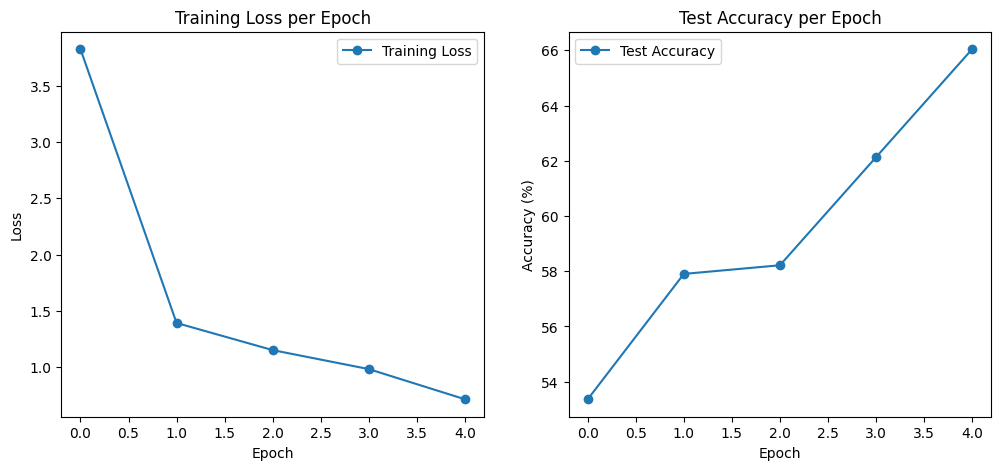

In [10]:
# 훈련 손실 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 테스트 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, 'o-', label='Test Accuracy')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# 그래프 표시
plt.show()

#메모리를 초과함

In [11]:
# import cv2
# from google.colab.patches import cv2_imshow

# # 모델과 라벨링 맵, 트랜스폼을 불러옵니다.
# model.eval()

# # 동영상 파일을 불러옵니다.
# video_path = '/content/drive/MyDrive/zerobase/project_DL/경전철_나가기.mp4'
# cap = cv2.VideoCapture(video_path)

# # 결과를 저장할 비디오 설정
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # 현재 프레임에 대해 모델이 처리할 수 있는 형태로 변환합니다.
#     input_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#     input_frame = transform(input_frame).unsqueeze(0).to(device)

#     # 탐지 수행
#     with torch.no_grad():
#         predictions = model(input_frame)

#     # 예측값을 CPU로 옮기고 numpy 배열로 변환합니다.
#     predictions = predictions.cpu().numpy()

#     # 예측 결과를 프레임에 오버레이합니다 (여기서는 예시를 위한 단순 텍스트 오버레이입니다).
#     label = label_mapping.get(predictions.argmax(1)[0], "Unknown")
#     cv2.putText(frame, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#     # 결과 비디오에 프레임을 씁니다.
#     out.write(frame)
#     # Colab에서 프레임을 표시합니다.
#     cv2_imshow(frame)

#     # 'q'를 입력 받으면 루프를 종료합니다.
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # 작업이 완료되면 해제합니다.
# cap.release()
# out.release()


동영상만 뽑아냄... 오류 수정해야..


In [19]:
import cv2
import torch
from PIL import Image
from torchvision import transforms

# 모델을 평가 모드로 설정
model.eval()

# 이미지 변환(transform) 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 라벨 매핑 설정
label_mapping = {
    # 여러분의 라벨 매핑을 여기에 설정하세요.
}

# 동영상 파일을 불러옵니다.
video_path = '/content/drive/MyDrive/zerobase/project_DL/경전철_나가기.mp4'
cap = cv2.VideoCapture(video_path)

# 결과를 저장할 비디오 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/drive/MyDrive/zerobase/project_DL/test2.mp4', fourcc, 20.0,
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# 프레임 카운터 초기화
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 5프레임마다 처리
    if frame_count % 5 == 0:
        # 현재 프레임에 대해 모델이 처리할 수 있는 형태로 변환
        input_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        input_frame = transform(input_frame).unsqueeze(0)  # 모델 입력 형태로 변환

        # 모델로 탐지 수행
        with torch.no_grad():
            predictions = model(input_frame)

        # 예측값을 CPU로 옮기고 numpy 배열로 변환
        predictions = predictions.cpu().numpy()

        # 예측 결과를 프레임에 오버레이
        label = label_mapping.get(predictions.argmax(1)[0], "Unknown")
        cv2.putText(frame, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # 결과 비디오에 프레임을 씁니다.
    out.write(frame)

    frame_count += 1

# 작업이 완료되면 자원을 해제합니다.
cap.release()
out.release()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor